Median velocity:
1.2843137254901962
25th percentile velocity:
0.8413867822318526
75th percentile velocity:
1.6939077776156426


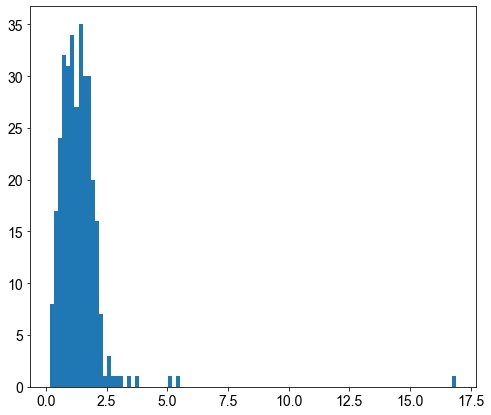

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 

    
trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
scour_table_global = pd.read_csv('3rd_party/S2_l_scour_table.csv')

Abf = trampush_2014['Abf [m2]']
Qbf = trampush_2014['Qbf [m3/s]']


fig, ax = plt.subplots(figsize=(8, 7))
ax.hist(Qbf/Abf, 100)
print('Median velocity:')
print(np.nanmedian(Qbf/Abf))
print('25th percentile velocity:')
print(np.nanpercentile(Qbf/Abf, 25))
print('75th percentile velocity:')
print(np.nanpercentile(Qbf/Abf, 75))
plt.show()




In [ ]:

Wbf = trampush_2014['Wbf [m]']
Hbf = trampush_2014['Hbf [m]']
slope = trampush_2014['S [-]']
D50_mm = trampush_2014['D50 [mm]']
D50 = trampush_2014['D50 [mm]']/1000

# Hbf_deltas = scour_table_global['Hbf [m]']
# slope_deltas = scour_table_global['S [-]']
# D50_deltas = scour_table_global['D50 [m]']

# D50.append(D50_deltas)
# Hbf.append(Hbf_deltas)
# slope.append(slope_deltas)

def power_law(x, a, b):
    return a*np.power(x,b)

def logfunc(X, a, b, c):
    x,y = X
    return np.log(a) + b*np.log(x) + c*np.log(y)


# Original fit parameters
a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50


Hbf_trampush = lambda slope, D50: np.exp((np.log10(slope) - a0 - (a1 * np.log10(D50)))/a2)

# New log fit
a0_refit = 0.03789887
a1_refit  = -0.00227301
a2_refit  = 1.07673782

D50_trampush_refit = lambda Hbf, slope: np.exp(a0_refit+a1_refit*np.log10(Hbf)+a2_refit*np.log10(slope))

Wbf_nan_mask = ~np.isnan(Wbf)
Wbf_no_nans = Wbf[Wbf_nan_mask]
Hbf_no_nans = Hbf[Wbf_nan_mask]

# Fit the grain size and tbf

D50_estimated = D50_trampush(Hbf, slope)
D50_estimated2 = D50_trampush_refit(Hbf, slope)
Hbf_estimated = Hbf_trampush(slope, D50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.scatter(D50, D50_estimated, alpha=0.4, color='xkcd:blue')
ax.scatter(D50, D50_estimated2, alpha=0.4, color='xkcd:red')

ax.plot([0, 10], [0, 10], 'k')

ax.set_xlabel('D50 (Reported)')
ax.set_ylabel('D50 (Estimated)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid('on')
ax.legend(['1:1 line', '2014 Fit', 'New fit'])
ax.set_ylim([0.00001, 10])
ax.set_xlim([0.00001, 10])

m = len(D50_estimated)

# mean squared error
mse = np.sum((D50_estimated - D50)**2)

# root mean squared error
# m is the number of training examples
rmse = np.sqrt(mse/m)


print('Trampush Original Fit RMSE: '+str(rmse))

# mean squared error
mse = np.sum((D50_estimated2 - D50)**2)

# root mean squared error
# m is the number of training examples
rmse = np.sqrt(mse/m)

print('Trampush New Fit RMSE: '+str(rmse))

## Full Grain Size Curve Fit

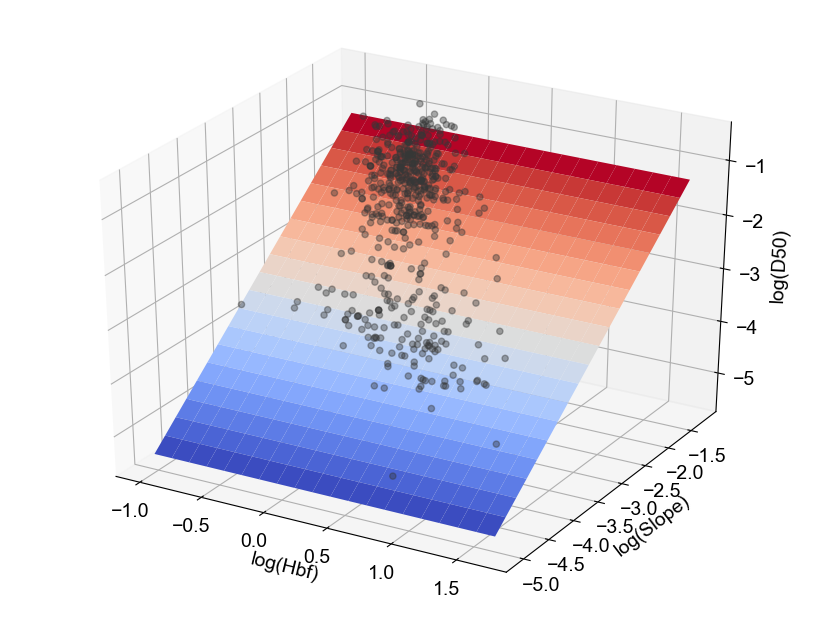

fitted parameters [ 0.03789887 -0.00227301  1.07673782]
RMSE: 0.04075999307618289
R-squared: 0.09569580618856321


In [14]:
import numpy, scipy, scipy.optimize
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator


trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
scour_table_global = pd.read_csv('3rd_party/S2_l_scour_table.csv')

Abf = trampush_2014['Abf [m2]']
Qbf = trampush_2014['Qbf [m3/s]']
Wbf = trampush_2014['Wbf [m]']
Hbf = trampush_2014['Hbf [m]']
slope = trampush_2014['S [-]']
D50_mm = trampush_2014['D50 [mm]']
D50 = trampush_2014['D50 [mm]']/1000

Hbf_deltas = scour_table_global['Hbf [m]']
slope_deltas = scour_table_global['S [-]']
D50_deltas = scour_table_global['D50 [m]']

# D50.append(D50_deltas)
# Hbf.append(Hbf_deltas)
# slope.append(slope_deltas)

graphWidth = 800 # units are pixels
graphHeight = 600 # units are pixels

# 3D contour plot lines
numberOfContourLines = 16

xData = Hbf
yData = slope
zData = D50

# place the data in a single list
data = [xData, yData, zData]


def SurfacePlot(func, data, fittedParameters):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    mpl.pyplot.grid(True)
    axes = Axes3D(f)

    # extract data from the single list
    x_data = np.log10(data[0])
    y_data = np.log10(data[1])
    z_data = np.log10(data[2])

    xModel = numpy.linspace(min(x_data), max(x_data), 20)
    yModel = numpy.linspace(min(y_data), max(y_data), 20)
    X, Y = numpy.meshgrid(xModel, yModel)

    Z = func(numpy.array([X, Y]), *fittedParameters)

    axes.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=1, antialiased=True)

    axes.scatter(x_data, y_data, z_data, color='xkcd:dark gray', alpha=0.4)

    axes.set_xlabel('log(Hbf)')
    axes.set_ylabel('log(Slope)')
    axes.set_zlabel('log(D50)')
    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems

def ScatterPlot(data):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    mpl.pyplot.grid(True)
    axes = Axes3D(f)

    # extract data from the single list
    x_data = np.log10(data[0])
    y_data = np.log10(data[1])
    z_data = np.log10(data[2])

    axes.scatter(x_data, y_data, z_data, color='xkcd:dark gray', alpha=0.4)

    axes.set_xlabel('log(Hbf)')
    axes.set_ylabel('log(Slope)')
    axes.set_zlabel('log(D50)')

    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def func(X, a, b, c):
    x,y = X
    return a+b*x+c*y


if __name__ == "__main__":
    initialParameters = [1.0, 1.0, 1.0] # these are the same as scipy default values in this example

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, [xData, yData], zData, p0 = initialParameters,  bounds=(-np.inf, np.inf))

    ScatterPlot(data)
    SurfacePlot(func, data, fittedParameters)

    print('fitted parameters', fittedParameters)

    modelPredictions = func([xData, yData], *fittedParameters)

    absError = modelPredictions - zData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(zData))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)


[20.50970528 -0.51797231]


Text(0, 0.5, '$T_{bf}*$')

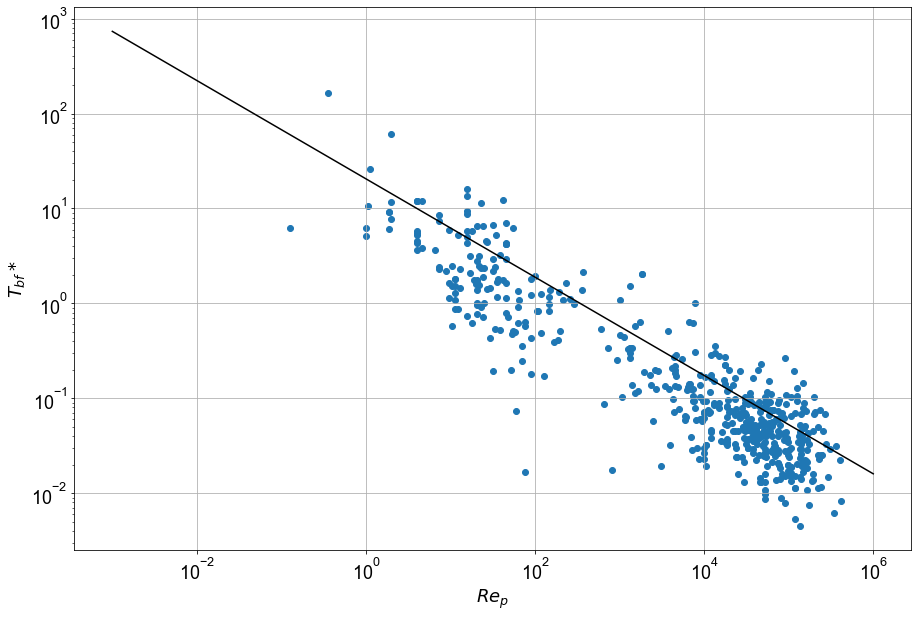

In [27]:
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 

    
    
# Rep vs Tbf

def power_law(x, a, b):
    return a*np.power(x,b)

R = 1.65
v = 1.0035E-06
g = 9.78

rho = 1000

# Particle Reynolds Number
Rep = lambda D: (np.sqrt(R*g)/v)*np.power(D, 3/2)
Tbf = lambda H, sl, D: (H*sl)/(R*D)


Rep_dat = Rep(D50)
Tbf_dat = Tbf(Hbf, slope, D50)


params, pcov = scipy.optimize.curve_fit(power_law, Rep_dat, Tbf_dat, p0 = [0,0],  bounds=(-np.inf, np.inf))

print(params)

x_predict = np.linspace(0.001, 1000000, 100)
y_predict = params[0]*np.power(x_predict, params[1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ax.scatter(Rep_dat, Tbf_dat)
ax.plot(x_predict, y_predict, 'k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.grid('on')
ax.set_xlabel('$Re_{p}$')
ax.set_ylabel('$T_{bf}*$')



In [ ]:
# Global Rivers Test



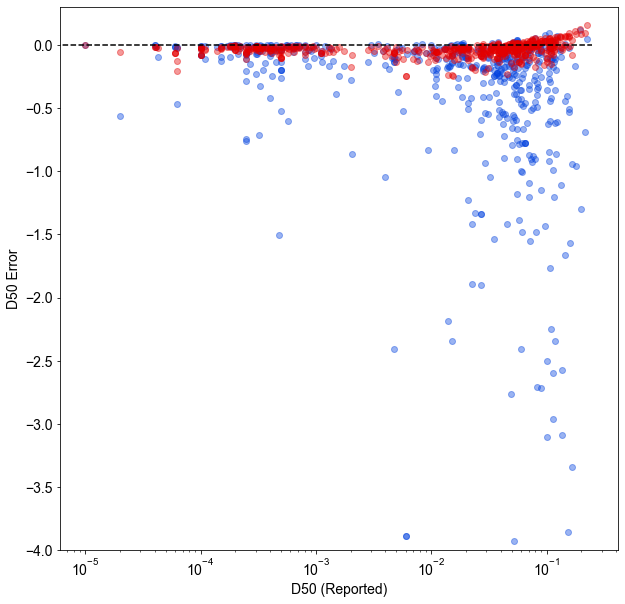

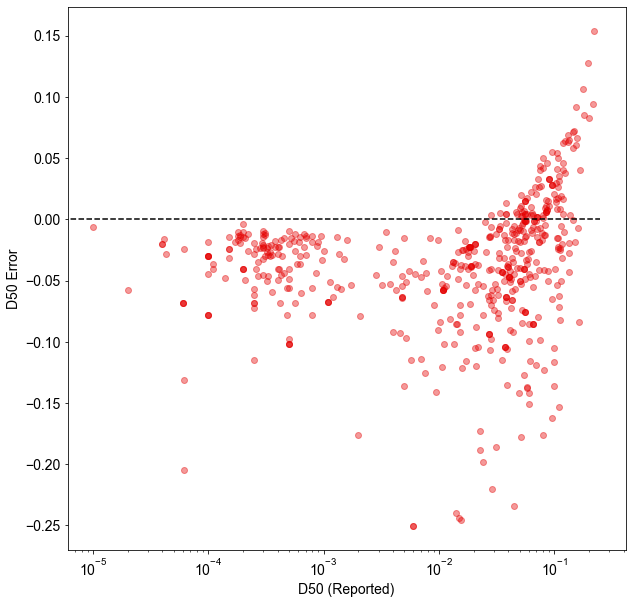

In [28]:
# can we improve the regression?

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 

    
trampush_2014 = pd.read_csv('3rd_party/trampush_2014_utf8.csv')
scour_table_global = pd.read_csv('3rd_party/S2_l_scour_table.csv')

Abf = trampush_2014['Abf [m2]']
Qbf = trampush_2014['Qbf [m3/s]']
Wbf = trampush_2014['Wbf [m]']
Hbf = trampush_2014['Hbf [m]']
slope = trampush_2014['S [-]']
D50_mm = trampush_2014['D50 [mm]']
D50 = trampush_2014['D50 [mm]']/1000

Hbf_deltas = scour_table_global['Hbf [m]']
slope_deltas = scour_table_global['S [-]']
D50_deltas = scour_table_global['D50 [m]']

# D50.append(D50_deltas)
# Hbf.append(Hbf_deltas)
# slope.append(slope_deltas)

def power_law(x, a, b):
    return a*np.power(x,b)

def logfunc(X, a, b, c):
    x,y = X
    return np.log(a) + b*np.log(x) + c*np.log(y)


# Original fit parameters
a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50
Hbf_trampush = lambda slope, D50: np.exp((np.log10(slope) - a0 - (a1 * np.log10(D50)))/a2)

# New log fit
a0_refit = 0.03789887
a1_refit  = -0.00227301
a2_refit  = 1.07673782

D50_trampush_refit = lambda Hbf, slope: np.exp(a0_refit+a1_refit*np.log10(Hbf)+a2_refit*np.log10(slope))

Wbf_nan_mask = ~np.isnan(Wbf)
Wbf_no_nans = Wbf[Wbf_nan_mask]
Hbf_no_nans = Hbf[Wbf_nan_mask]

# Fit the grain size and tbf

D50_estimated = D50_trampush(Hbf, slope)
D50_estimated2 = D50_trampush_refit(Hbf, slope)
Hbf_estimated = Hbf_trampush(slope, D50)


error = D50-D50_estimated
error2 = D50-D50_estimated2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.scatter(D50, error, alpha=0.4, color='xkcd:blue')
ax.scatter(D50, error2, alpha=0.4, color='xkcd:red')

ax.plot([0, 0.25], [0, 0], 'k--')
ax.set_xlabel('D50 (Reported)')
ax.set_ylabel('D50 Error')
ax.set_xscale('log')
ax.set_ylim([-4, 0.3])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.scatter(D50, error2, alpha=0.4, color='xkcd:red')

ax.plot([0, 0.25], [0, 0], 'k--')
ax.set_xlabel('D50 (Reported)')
ax.set_ylabel('D50 Error')
ax.set_xscale('log')


In [7]:
import numpy as np


# Agos River depth
D50 = 0.34/1000
#slope = 0.004012071
slope = 1/492
print(slope)
# Original fit parameters
a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50


Hbf_trampush = lambda slope, D50: np.exp((np.log10(slope) - a0 - (a1 * np.log10(D50)))/a2)

print(Hbf_trampush(slope, D50))

0.0020325203252032522
0.7812774034632916
